## Density - pericenter slope

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import os

from density_profile_fit_utils import fit_nfw_model, fit_core_nfw_model, fit_isothermal_model
from density_profile_utils import NFW_profile
from density_pericenter_fit_utils import run_best_fit_for_sim

In [2]:
import matplotlib

plt.style.use("pltstyle.mplstyle")
mycmap = matplotlib.cm.RdYlBu
myblue = mycmap(0.9)
myred =  mycmap(0.1)
color_list = ['olivedrab', myblue, 'peru', myred, 'darkorchid'] # 'midnightblue'])

In [3]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

## Slope plots - 8

In [4]:
MAX_SATELLITES = 8

#### Best fit

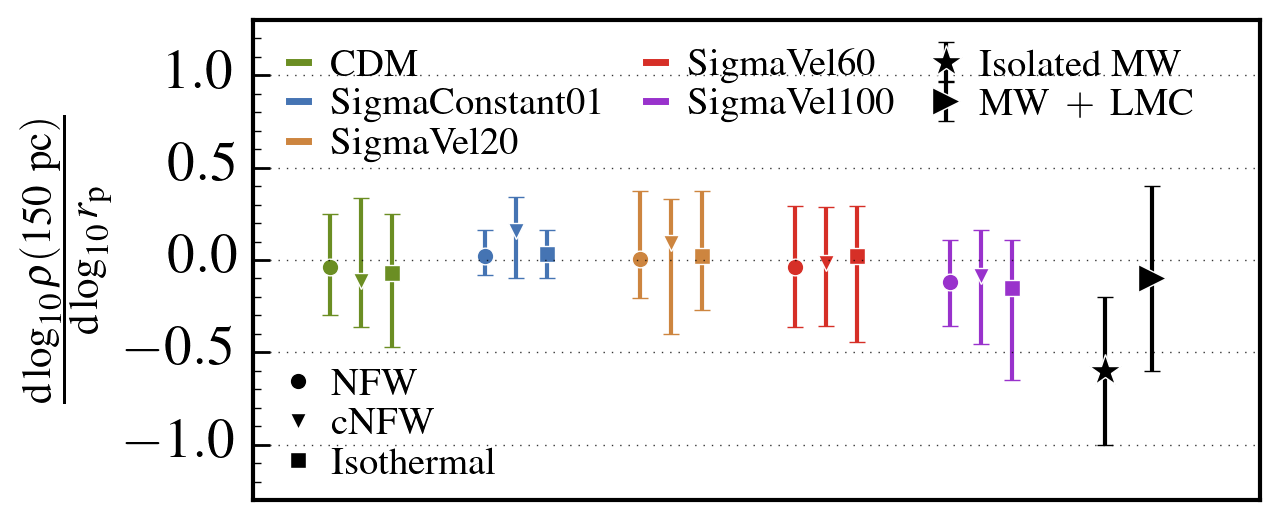

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    # Get NFW profile
                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                    
                    # Get core-NFW profile
                    core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                    log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                    _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                    rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                    
                    # Get ISO profile
                    iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                    r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                    _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                    rho150_iso = np.append(rho150_iso, _rho_150[0])
                    
                    counter+=1
            
            
            if counter<8: continue # Fit only systems with at least 8 satellites
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)
    

    fraction_nfw = np.where(m_nfw<-0.5)[0]
    fraction_cnfw = np.where(m_core_nfw<-0.5)[0]
    fraction_iso = np.where(m_iso<-0.5)[0]

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    # print(f"{id_name} NFW: {np.median(m_nfw)}",len(fraction_nfw)/len(m_nfw))
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    # print(f"{id_name} cNFW: {np.median(m_core_nfw)}",len(fraction_cnfw)/len(m_core_nfw))
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')

    # print(f"{id_name} ISO: {np.median(m_iso)}",len(fraction_iso)/len(m_iso))
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_best_fit_{MAX_SATELLITES}.png', dpi=300)
plt.show()

## Slope plots - all

If we were to relax the assumption on eight most massive - lower probability of them having simulated systems in agreement with isoleted MW. Spread is decreasing. 

In [6]:
MAX_SATELLITES = None

#### Best fit

CDM NFW: -0.08939467239562858
CDM cNFW: -0.09607985878393603
CDM ISO: -0.15497523849994554
SigmaConstant01 NFW: -0.04910195064232969
SigmaConstant01 cNFW: 0.0040282194818225215
SigmaConstant01 ISO: -0.05571593990424394
SigmaVel20 NFW: -0.07028254540462665
SigmaVel20 cNFW: 0.01870326699565032
SigmaVel20 ISO: -0.062048822570948216
SigmaVel60 NFW: -0.02496439528199086
SigmaVel60 cNFW: -0.0248263147279267
SigmaVel60 ISO: -0.06312282459728814
SigmaVel100 NFW: -0.22455317788748105
SigmaVel100 cNFW: -0.17934715206469493
SigmaVel100 ISO: -0.24891347500057917


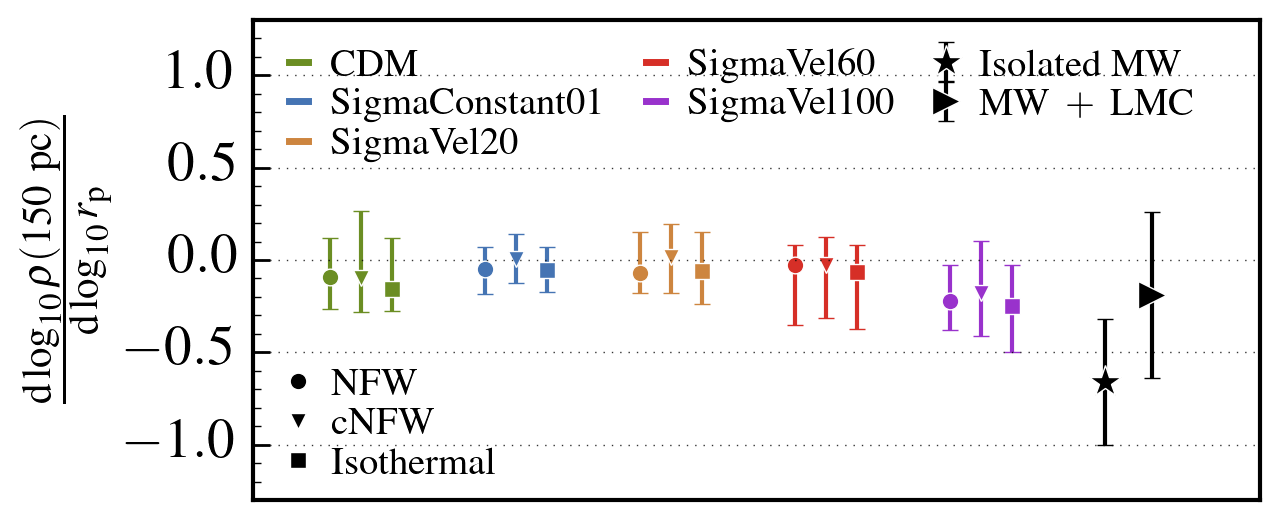

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    # Get NFW profile
                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                    
                    # Get core-NFW profile
                    core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                    log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                    _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                    rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                    
                    # Get ISO profile
                    iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                    r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                    _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                    rho150_iso = np.append(rho150_iso, _rho_150[0])
                    
                    counter+=1
            
            
            if counter<8: continue# Fit only systems with at least 8 satellites
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} NFW: {np.median(m_nfw)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} cNFW: {np.median(m_core_nfw)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} ISO: {np.median(m_iso)}")
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.66), yerr=np.ones((2, 1))*0.34, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.19), yerr=np.ones((2, 1))*0.45, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_best_fit_{MAX_SATELLITES}.png', dpi=200)
plt.show()

### Data fits

#### Best fit adding all Cardona combinations

CDM NFW: (-0.08939467239562858, -0.2679826563362087, 0.11852654860366048)
CDM cNFW: (-0.09607985878393603, -0.2795108756820807, 0.2676504482154947)
CDM ISO: (-0.15497523849994554, -0.276876896685412, 0.12961232709856824)
SigmaConstant01 NFW: (-0.04910195064232969, -0.18402690962824692, 0.0690055895805944)
SigmaConstant01 cNFW: (0.0040282194818225215, -0.12225600977360279, 0.1400894634438292)
SigmaConstant01 ISO: (-0.05571593990424394, -0.17200734985812863, 0.06595992234619207)
SigmaVel20 NFW: (-0.07028254540462665, -0.18076926668368856, 0.15391202193532202)
SigmaVel20 cNFW: (0.01870326699565032, -0.17855432494416487, 0.19637978639696155)
SigmaVel20 ISO: (-0.062048822570948216, -0.23692265402121485, 0.1630317759922064)
SigmaVel60 NFW: (-0.02496439528199086, -0.35026213092384034, 0.07942661515008971)
SigmaVel60 cNFW: (-0.0248263147279267, -0.31580143178694425, 0.12472670006584809)
SigmaVel60 ISO: (-0.06312282459728814, -0.37377365848455585, 0.0687655610289977)
SigmaVel100 NFW: (-0.224553

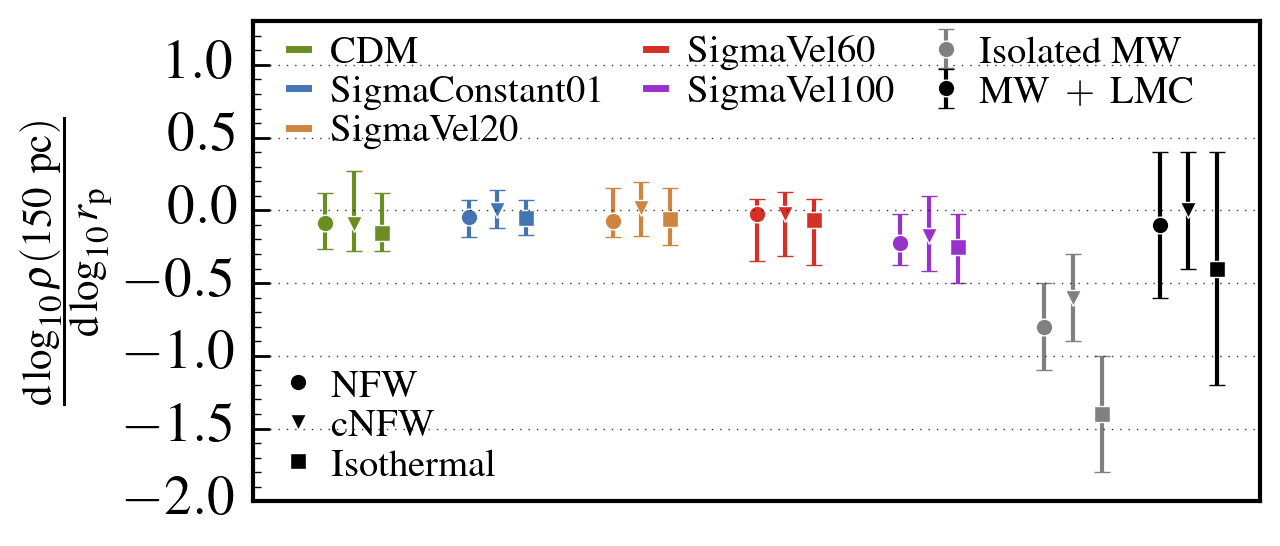

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            counter = 0 
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    # Get NFW profile
                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                    
                    # Get core-NFW profile
                    core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                    log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                    _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                    rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                    
                    # Get ISO profile
                    iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                    r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                    _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                    rho150_iso = np.append(rho150_iso, _rho_150[0])
                    
                    counter +=1
            
            if counter<8: continue # Fit only systems with at least 8 satellites
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} NFW: {np.median(m_nfw), np.percentile(m_nfw,16), np.percentile(m_nfw,84)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} cNFW: {np.median(m_core_nfw), np.percentile(m_core_nfw,16), np.percentile(m_core_nfw,84)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} ISO: {np.median(m_iso), np.percentile(m_iso,16), np.percentile(m_iso,84)}")
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
# Plot rho_K19NFW + rp P20
plt.errorbar(np.array([i+1]), np.array(-0.8), yerr=np.ones((2, 1))*0.3, marker='o', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='grey')
# Plot rho_R19 + rp P20
plt.errorbar(np.array([i+1.2]), np.array(-0.6), yerr=np.ones((2, 1))*0.3, marker='v', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='grey')
# Plot rho_K19ISO + rp P20
plt.errorbar(np.array([i+1.4]), np.array(-1.4), yerr=np.ones((2, 1))*0.4, marker='s', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='grey')

# Plot rho_K19NFW + rp B20 (+LMC)
plt.errorbar(np.array([i+1.8]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='o', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
# Plot rho_R19 + rp B20 (+LMC)
plt.errorbar(np.array([i+2.0]), np.array(0), yerr=np.ones((2, 1))*0.4, marker='v', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='black')
# Plot rho_K19ISO + rp B20 (+LMC)
plt.errorbar(np.array([i+2.2]), np.array(-0.4), yerr=np.ones((2, 1))*0.8, marker='s', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='black')

plt.xticks([])
plt.xlim([-0.5, 6.5])
plt.ylim([-2.0, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.7], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_best_fit.png', dpi=300)
plt.show()

#### Best fit adding all our fitted combinations

In [14]:
from scipy.optimize import curve_fit
from density_pericenter_fit_utils import log_model, run_best_fit_for_sim

GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()
Read_data = pd.read_csv(GAIA_PATH+"Read_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

num_satellites = len(dSph)

# We remove CVnI
num_satellites = 8
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW
rho_150pc_R19 = np.zeros((3,num_satellites)) # Reading Read+ 2019 determination under core-NFW
rho_150pc_K19ISO = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under Isothermal


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19ISO[0,i] = data[9,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19ISO[1,i] = data[9,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19ISO[2,i] = data[9,2] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_R19[0,i] = data[6,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_R19[1,i] = data[6,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_R19[2,i] = data[6,2] * 1e7 # Central density [Msun/kpc^3]
    
    
# We do the fitting for observations (NFW)

popt_p_Isolated, pcov = curve_fit(log_model, np.log10(r_p_Isolated[0,:]), np.log10(rho_150pc_K19[0,:]/1e7))
perr_p_Isolated = np.sqrt(np.diag(pcov))
print(popt_p_Isolated, perr_p_Isolated)
popt_p_LMC, pcov = curve_fit(log_model, np.log10(r_p_LMC[0,:]), np.log10(rho_150pc_K19[0,:]/1e7))
perr_p_LMC = np.sqrt(np.diag(pcov))
print(popt_p_LMC, perr_p_LMC)

# We do the fitting for observations (ISO)

popt_p_Isolated_ISO, pcov_ISO = curve_fit(log_model, np.log10(r_p_Isolated[0,:]), np.log10(rho_150pc_K19ISO[0,:]/1e7))
perr_p_Isolated_ISO = np.sqrt(np.diag(pcov_ISO))
print(popt_p_Isolated_ISO, perr_p_Isolated_ISO)
popt_p_LMC_ISO, pcov_ISO = curve_fit(log_model, np.log10(r_p_LMC[0,:]), np.log10(rho_150pc_K19ISO[0,:]/1e7))
perr_p_LMC_ISO = np.sqrt(np.diag(pcov_ISO))
print(popt_p_LMC_ISO, perr_p_LMC_ISO)

# We do the fitting for observations (cNFW)

popt_p_Isolated_cNFW, pcov_cNFW = curve_fit(log_model, np.log10(r_p_Isolated[0,:]), np.log10(rho_150pc_R19[0,:]/1e7))
perr_p_Isolated_cNFW = np.sqrt(np.diag(pcov_cNFW))
print(popt_p_Isolated_cNFW, perr_p_Isolated_cNFW)
popt_p_LMC_cNFW, pcov_cNFW = curve_fit(log_model, np.log10(r_p_LMC[0,:]), np.log10(rho_150pc_R19[0,:]/1e7))
perr_p_LMC_cNFW = np.sqrt(np.diag(pcov_cNFW))
print(popt_p_LMC_cNFW, perr_p_LMC_cNFW)

[ 2.30112007 -0.66128207] [0.58704218 0.34001611]
[ 1.51969014 -0.19019314] [0.84792992 0.4520326 ]
[ 3.09456537 -1.18637109] [0.94292005 0.54614135]
[ 2.11653988 -0.5678892 ] [1.37961341 0.73547379]
[ 1.87040757 -0.41074682] [0.54078178 0.31322199]
[ 1.35839351 -0.10389114] [0.69953822 0.37292477]


CDM NFW: (-0.08939467239562858, -0.2679826563362087, 0.11852654860366048)
CDM cNFW: (-0.09607985878393603, -0.2795108756820807, 0.2676504482154947)
CDM ISO: (-0.15497523849994554, -0.276876896685412, 0.12961232709856824)
SigmaConstant01 NFW: (-0.04910195064232969, -0.18402690962824692, 0.0690055895805944)
SigmaConstant01 cNFW: (0.0040282194818225215, -0.12225600977360279, 0.1400894634438292)
SigmaConstant01 ISO: (-0.05571593990424394, -0.17200734985812863, 0.06595992234619207)
SigmaVel20 NFW: (-0.07028254540462665, -0.18076926668368856, 0.15391202193532202)
SigmaVel20 cNFW: (0.01870326699565032, -0.17855432494416487, 0.19637978639696155)
SigmaVel20 ISO: (-0.062048822570948216, -0.23692265402121485, 0.1630317759922064)
SigmaVel60 NFW: (-0.02496439528199086, -0.35026213092384034, 0.07942661515008971)
SigmaVel60 cNFW: (-0.0248263147279267, -0.31580143178694425, 0.12472670006584809)
SigmaVel60 ISO: (-0.06312282459728814, -0.37377365848455585, 0.0687655610289977)
SigmaVel100 NFW: (-0.224553

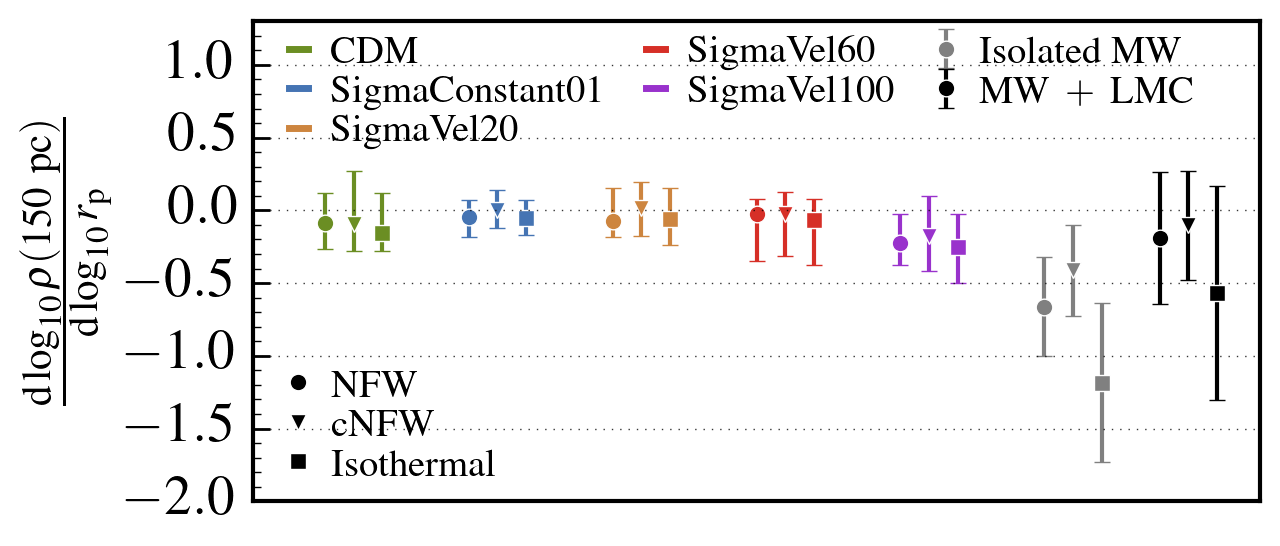

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            counter = 0 
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    # Get NFW profile
                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                    
                    # Get core-NFW profile
                    core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                    log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                    _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                    rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                    
                    # Get ISO profile
                    iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                    r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                    _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                    rho150_iso = np.append(rho150_iso, _rho_150[0])
                    
                    counter +=1
            
            if counter<8: continue # Fit only systems with at least 8 satellites
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} NFW: {np.median(m_nfw), np.percentile(m_nfw,16), np.percentile(m_nfw,84)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} cNFW: {np.median(m_core_nfw), np.percentile(m_core_nfw,16), np.percentile(m_core_nfw,84)}")
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    print(f"{id_name} ISO: {np.median(m_iso), np.percentile(m_iso,16), np.percentile(m_iso,84)}")
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
# Plot rho_K19NFW + rp P20
plt.errorbar(np.array([i+1]), popt_p_Isolated[1], yerr=np.ones((2, 1))*perr_p_Isolated[1], marker='o', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='grey')
# Plot rho_R19 + rp P20
plt.errorbar(np.array([i+1.2]), popt_p_Isolated_cNFW[1], yerr=np.ones((2, 1))*perr_p_Isolated_cNFW[1], marker='v', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='grey')
# Plot rho_K19ISO + rp P20
plt.errorbar(np.array([i+1.4]), popt_p_Isolated_ISO[1], yerr=np.ones((2, 1))*perr_p_Isolated_ISO[1], marker='s', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='grey')

# Plot rho_K19NFW + rp B20 (+LMC)
plt.errorbar(np.array([i+1.8]), popt_p_LMC[1], yerr=np.ones((2, 1))*perr_p_LMC[1], marker='o', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
# Plot rho_R19 + rp B20 (+LMC)
plt.errorbar(np.array([i+2.0]), popt_p_LMC_cNFW[1], yerr=np.ones((2, 1))*perr_p_LMC_cNFW[1], marker='v', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='black')
# Plot rho_K19ISO + rp B20 (+LMC)
plt.errorbar(np.array([i+2.2]), popt_p_LMC_ISO[1], yerr=np.ones((2, 1))*perr_p_LMC_ISO[1], marker='s', markersize=6, 
            markeredgecolor="white", ls='none', lw=1.5, color='black')

plt.xticks([])
plt.xlim([-0.5, 6.5])
plt.ylim([-2.0, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.7], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
# plt.savefig(f'figures/Density_pericenter_slope_best_fit.png', dpi=300)
plt.show()

#### How many m?

In [9]:
MAX_SATELLITES = None

filename = f"./outputs/fit_slope_NFW+cNFW+ISO_{MAX_SATELLITES}.npy" if MAX_SATELLITES is not None else "./outputs/fit_slope_NFW+cNFW+ISO.npy"
m_save_NFW, m_save_cNFW, m_save_ISO = np.load(filename, allow_pickle=True)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")
        
    print(id_name)
    
    m_nfw = m_save_NFW[i]
    m_core_nfw = m_save_cNFW[i]
    m_iso = m_save_ISO[i]
        
    print("NFW")
    print('m<-0.5:', (m_nfw < -0.5).sum()/len(m_nfw))
    print('m<-0.4:', (m_nfw < -0.4).sum()/len(m_nfw))
    print('m<-0.3:', (m_nfw < -0.3).sum()/len(m_nfw))
    print(f"{id_name} NFW: {np.median(m_nfw)}")
    
    print("cNFW")
    print('m<-0.5:', (m_core_nfw < -0.5).sum()/len(m_core_nfw))
    print('m<-0.4:', (m_core_nfw < -0.4).sum()/len(m_core_nfw))
    print('m<-0.3:', (m_core_nfw < -0.3).sum()/len(m_core_nfw))
    print(f"{id_name} NFW: {np.median(m_core_nfw)}")
    
    print("ISO")
    print('m<-0.5:', (m_iso< - 0.5).sum()/len(m_iso))
    print('m<-0.4:', (m_iso < -0.4).sum()/len(m_iso))
    print('m<-0.3:', (m_iso< - 0.3).sum()/len(m_iso))
    print(f"{id_name} NFW: {np.median(m_iso)}")
    
    print(" ")
    ####
    file.close()

CDM
NFW
m<-0.5: 0.0
m<-0.4: 0.0
m<-0.3: 0.12
CDM NFW: -0.08939402971655194
cNFW
m<-0.5: 0.0
m<-0.4: 0.04
m<-0.3: 0.16
CDM NFW: -0.09607800737805573
ISO
m<-0.5: 0.0
m<-0.4: 0.04
m<-0.3: 0.16
CDM NFW: -0.09607800737805573
 
SigmaConstant01
NFW
m<-0.5: 0.0
m<-0.4: 0.0
m<-0.3: 0.0
SigmaConstant01 NFW: -0.049097502615714134
cNFW
m<-0.5: 0.0
m<-0.4: 0.0
m<-0.3: 0.0
SigmaConstant01 NFW: 0.004028840540832122
ISO
m<-0.5: 0.0
m<-0.4: 0.0
m<-0.3: 0.0
SigmaConstant01 NFW: 0.004028840540832122
 
SigmaVel20
NFW
m<-0.5: 0.0
m<-0.4: 0.0
m<-0.3: 0.12
SigmaVel20 NFW: -0.07028598682487522
cNFW
m<-0.5: 0.0
m<-0.4: 0.04
m<-0.3: 0.08
SigmaVel20 NFW: 0.018713896243552207
ISO
m<-0.5: 0.0
m<-0.4: 0.04
m<-0.3: 0.08
SigmaVel20 NFW: 0.018713896243552207
 
SigmaVel60
NFW
m<-0.5: 0.0
m<-0.4: 0.038461538461538464
m<-0.3: 0.23076923076923078
SigmaVel60 NFW: -0.024962289808951828
cNFW
m<-0.5: 0.038461538461538464
m<-0.4: 0.11538461538461539
m<-0.3: 0.19230769230769232
SigmaVel60 NFW: -0.024828395737063844
ISO
m<-0.5: 

## Correlation coefficients

In [10]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

num_satellites = 8
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

In [11]:
x = np.log10(r_p_Isolated[0,:])
y = np.log10(rho_150pc_K19[0,:])
log_pearson_obs_MW = stats.pearsonr(x, y).statistic
log_spearman_obs_MW = stats.spearmanr(x, y).statistic
pearson_obs_MW = stats.pearsonr(r_p_Isolated[0,:], rho_150pc_K19[0,:]).statistic
spearman_obs_MW = stats.spearmanr(r_p_Isolated[0,:], rho_150pc_K19[0,:]).statistic

x = np.log10(r_p_LMC[0,:])
y = np.log10(rho_150pc_K19[0,:])
log_pearson_obs_MW_LMC = stats.pearsonr(x, y).statistic
log_spearman_obs_MW_LMC = stats.spearmanr(x, y).statistic
pearson_obs_MW_LMC = stats.pearsonr(r_p_LMC[0,:], rho_150pc_K19[0,:]).statistic
spearman_obs_MW_LMC = stats.spearmanr(r_p_LMC[0,:], rho_150pc_K19[0,:]).statistic



CDM Obs
-0.2373050680706532 -0.6218178555723977 -0.16929150703890178
-0.1728082174493011 -0.6064937402412918 -0.1082746910866055
===
SigmaConstant01 Obs
-0.13149771615065692 -0.6218178555723977 -0.16929150703890178
-0.12411935091946318 -0.6064937402412918 -0.1082746910866055
===
SigmaVel20 Obs
-0.10754032133906002 -0.6218178555723977 -0.16929150703890178
-0.11844502680865304 -0.6064937402412918 -0.1082746910866055
===
SigmaVel60 Obs
0.005066086160937115 -0.6218178555723977 -0.16929150703890178
-0.11327616219113612 -0.6064937402412918 -0.1082746910866055
===
SigmaVel100 Obs
-0.24570890157726805 -0.6218178555723977 -0.16929150703890178
-0.2119302593607104 -0.6064937402412918 -0.1082746910866055
===


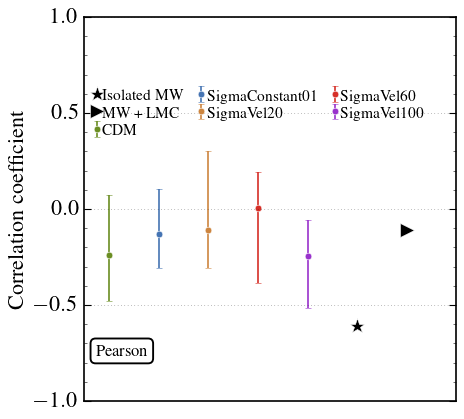

In [12]:
plt.figure()
ax = plt.subplot(1,1,1)
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    pearson_sim, log_pearson_sim = [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter  = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    rho_s = 10**log10_rho_s
                    _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                    rho150 = np.append(rho150, _rho_150[0])
                    
                    counter +=1
                    
            if counter<8: continue # only systems with at least 8 satellites
            
            pearson_sim = np.append(pearson_sim, stats.pearsonr(rp, rho150).statistic)
            x = np.log10(rp)
            y = np.log10(rho150)
            log_pearson_sim = np.append(log_pearson_sim, stats.pearsonr(x, y).statistic)

    print(id_name, 'Obs')
    print(np.median(log_pearson_sim), log_pearson_obs_MW, log_pearson_obs_MW_LMC)
    print(np.median(pearson_sim),pearson_obs_MW, pearson_obs_MW_LMC)
    print('===')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(log_pearson_sim) - np.percentile(log_pearson_sim,16)
    merr[1,0]= np.percentile(log_pearson_sim,84) - np.median(log_pearson_sim)
    plt.errorbar(np.array([i]), np.array(np.median(log_pearson_sim)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    file.close()

plt.plot(np.array([i+1]), np.array(pearson_obs_MW), marker='*', markersize=14, 
         markeredgecolor="white", label='Isolated MW', color='black')

plt.plot(np.array([i+2]), np.array(pearson_obs_MW_LMC), marker='>', markersize=12, 
         markeredgecolor="white", label='MW + LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.2, handlelength=0.3, handletextpad=0.2, 
           frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)
plt.xticks([])
plt.ylabel('Correlation coefficient')
plt.axis([-0.5, 7, -1, 1.0])

props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
plt.text(0.03, 0.15, 'Pearson', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)

####
# plt.savefig('figures/Density_pericenter_correlation_pearson.png',dpi=300)
plt.show()

CDM Obs
-0.2582417582417582 -0.6107893935757621 -0.023952525238265177
-0.2582417582417582 -0.6107893935757621 -0.023952525238265177
===
SigmaConstant01 Obs
-0.12990196078431374 -0.6107893935757621 -0.023952525238265177
-0.12990196078431374 -0.6107893935757621 -0.023952525238265177
===
SigmaVel20 Obs
-0.08131868131868132 -0.6107893935757621 -0.023952525238265177
-0.08131868131868132 -0.6107893935757621 -0.023952525238265177
===
SigmaVel60 Obs
-0.07542720437457279 -0.6107893935757621 -0.023952525238265177
-0.07542720437457279 -0.6107893935757621 -0.023952525238265177
===
SigmaVel100 Obs
-0.22549019607843138 -0.6107893935757621 -0.023952525238265177
-0.22549019607843138 -0.6107893935757621 -0.023952525238265177
===


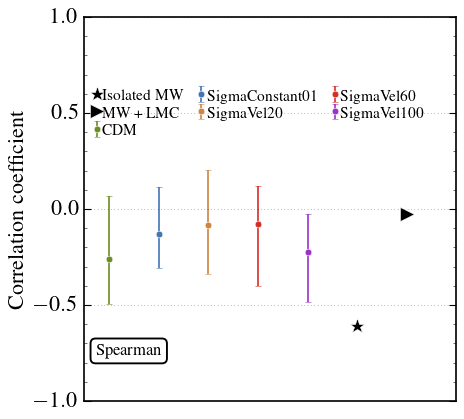

In [13]:
plt.figure()
ax = plt.subplot(1,1,1)
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    spearman_sim, log_spearman_sim = [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter  = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    rho_s = 10**log10_rho_s
                    _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                    rho150 = np.append(rho150, _rho_150[0])
                    
                    counter +=1
                    
            if counter<8: continue # only systems with at least 8 satellites
            
            spearman_sim = np.append(spearman_sim, stats.spearmanr(rp, rho150).statistic)
            x = np.log10(rp)
            y = np.log10(rho150)
            log_spearman_sim = np.append(log_spearman_sim, stats.spearmanr(x, y).statistic)

    print(id_name, 'Obs')
    print(np.median(log_spearman_sim), log_spearman_obs_MW, log_spearman_obs_MW_LMC)
    print(np.median(log_spearman_sim),spearman_obs_MW, spearman_obs_MW_LMC)
    print('===')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(log_spearman_sim) - np.percentile(log_spearman_sim,16)
    merr[1,0]= np.percentile(log_spearman_sim,84) - np.median(log_spearman_sim)
    plt.errorbar(np.array([i]), np.array(np.median(log_spearman_sim)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    file.close()

plt.plot(np.array([i+1]), np.array(spearman_obs_MW), marker='*', markersize=14, 
         markeredgecolor="white", label='Isolated MW', color='black')

plt.plot(np.array([i+2]), np.array(spearman_obs_MW_LMC), marker='>', markersize=12, 
         markeredgecolor="white", label='MW + LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.2, handlelength=0.3, handletextpad=0.2, 
           frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)
plt.xticks([])
plt.ylabel('Correlation coefficient')
plt.axis([-0.5, 7, -1, 1.0])

props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
plt.text(0.03, 0.15, 'Spearman', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)

####
# plt.savefig('figures/Density_pericenter_correlation_spearman.png',dpi=300)
plt.show()

##### 